In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Review criteriaменьше 
Придерживайтесь стандартного алгоритма построения прогноза:

1) Визуальный анализ ряда  
2) Стабилизация дисперсии (при необходимости)  
3) Выбор порядка дифференцирования  
4) Выбор начальных приближений для p,q,P,Q  
5) Обучение и сравнение моделей-кандидатов, выбор победителя  
6) Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно  скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.  
7) Прогнозирование с помощью финальной модели.  
Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.  

In [3]:
data = pd.read_csv('C:\Machinelearning\Failikprogam\EKurs\A\\WAG_C_M.csv', sep = ';', header = 0)

In [4]:
### WAG.head()

### 1. Визуализируем ряд анализа данных

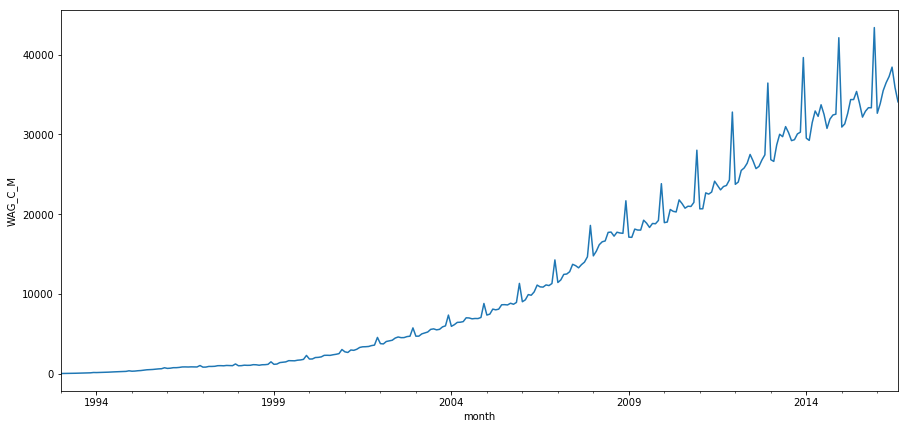

In [24]:
WAG = pd.read_csv('C:\Machinelearning\Failikprogam\EKurs\A\\WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
## WAG.WAG_C_M = WAG.WAG_C_M * 10
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

In [6]:
### data['month'] = pd.to_datetime(data['month'])

Критерий Дики-Фуллера: p=0.991850


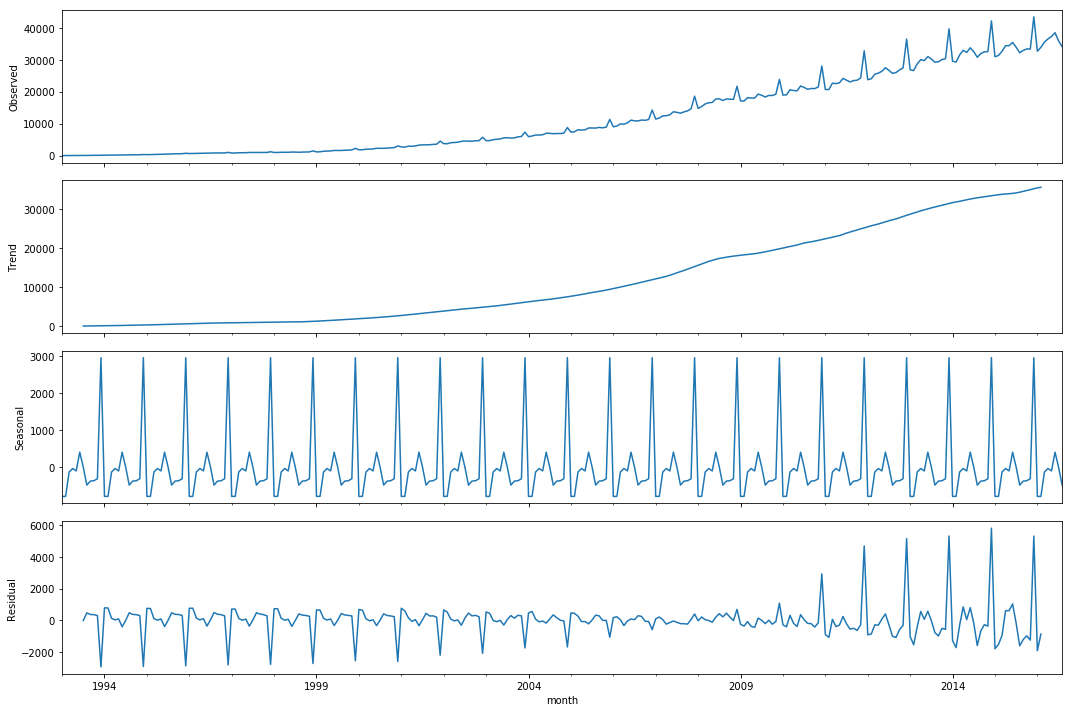

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M)[1])

Замечены сезонность и тренд

### 2

Оптимальный параметр преобразования Бокса-Кокса: 0.263202


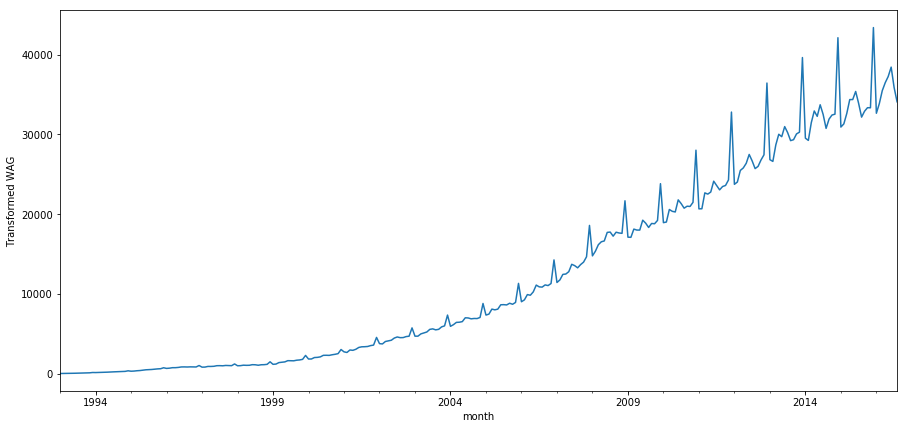

In [25]:
WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.WAG_C_M)
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
plt.ylabel(u'Transformed WAG')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
## print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M))[1])

### 3

Сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


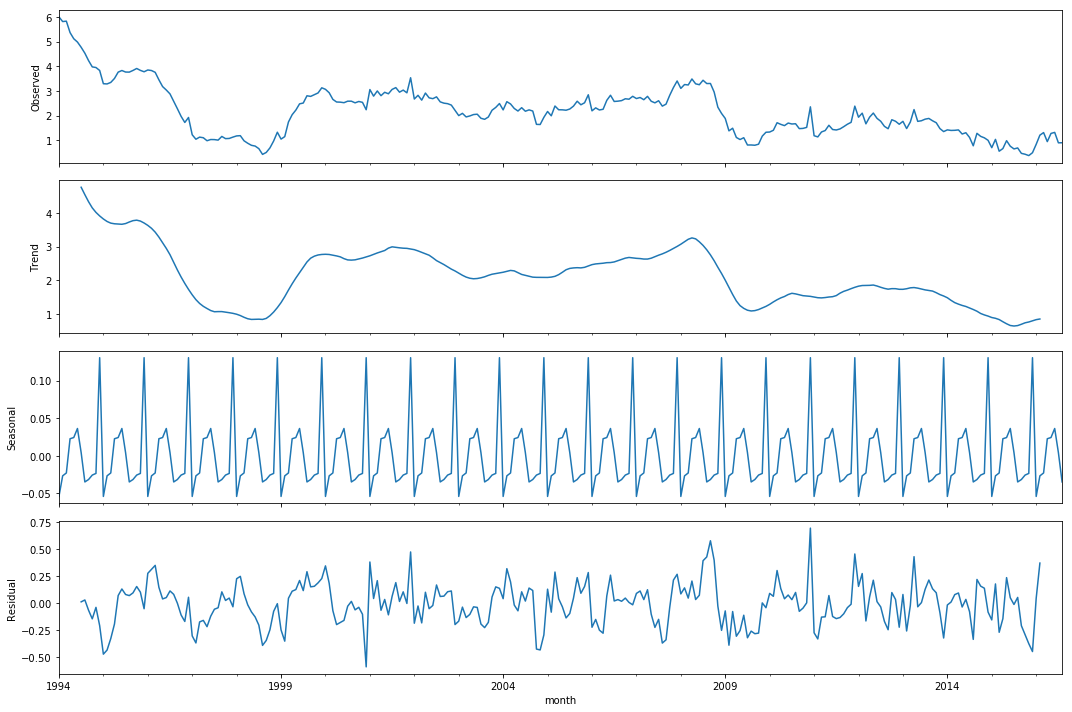

In [27]:
WAG['WAG_C_M_box_diff'] = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])

Обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


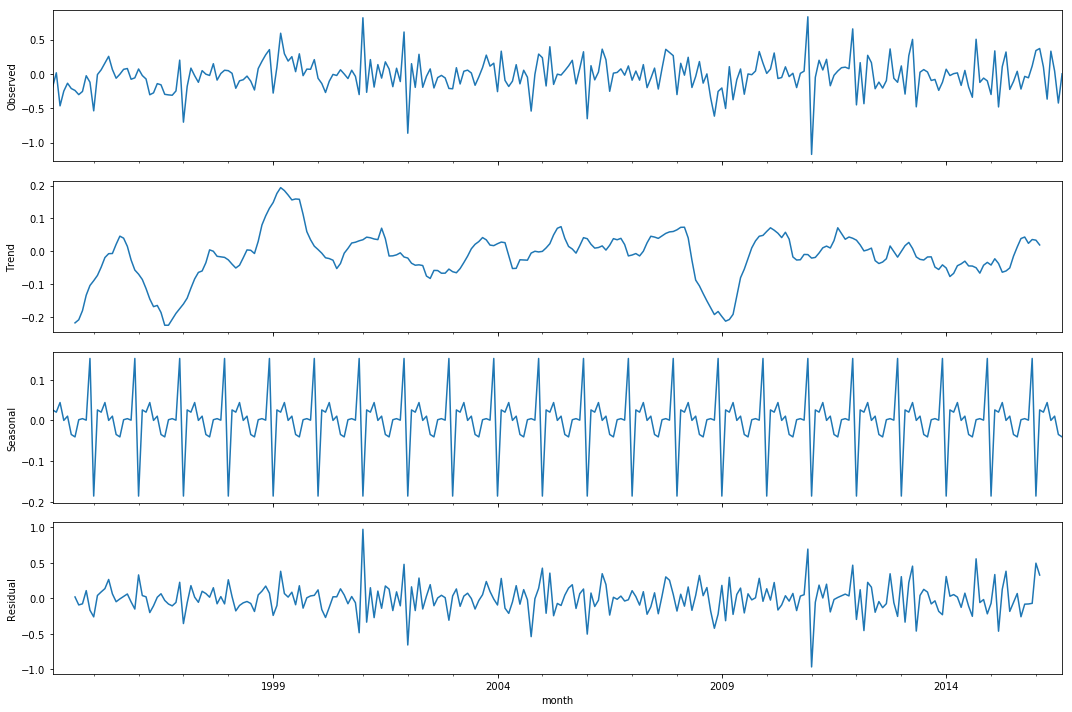

In [28]:
WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])

### 4

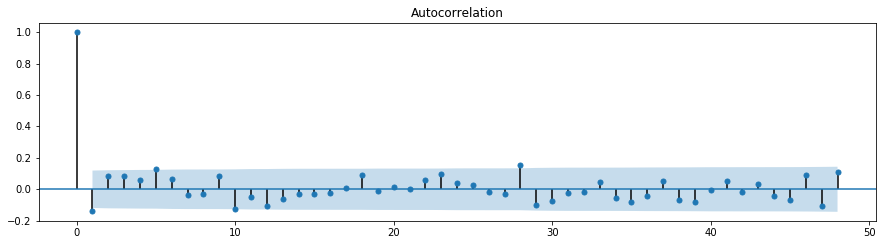

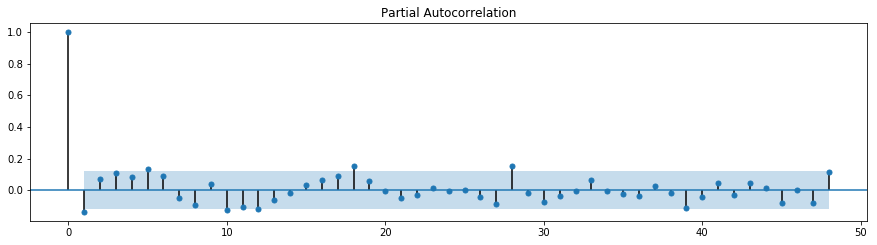

In [29]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [30]:
Q = 0
q = 2
P = 1
p = 2

In [31]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [32]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

18

### 5

In [40]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
Wall time: 2.8 s


In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
6   (1, 0, 1, 0)  0.340521
4   (0, 2, 1, 0)  0.509593
2   (0, 1, 1, 0)  1.170768
10  (2, 0, 1, 0)  1.533020
8   (1, 1, 1, 0)  2.021911


In [42]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 24 Apr 2018   AIC                              0.341
Time:                                    22:03:26   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

### 6

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


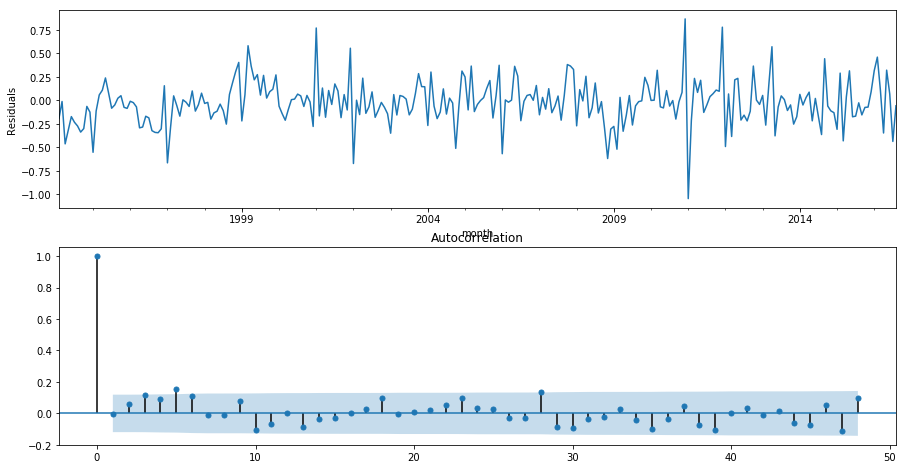

In [43]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [44]:
## WAG.WAG100 = WAG.WAG_C_M*10000

In [45]:
## WAG.WAG100 = WAG.WAG100 -700000

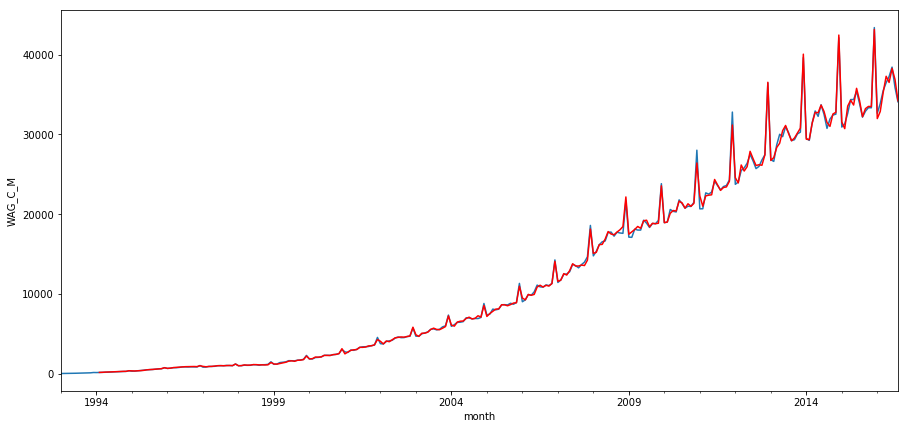

In [46]:
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

### 7

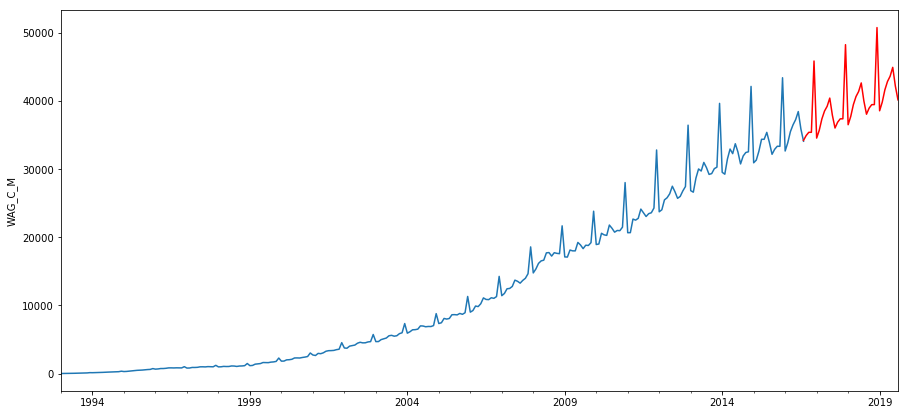

In [47]:
WAG2 = WAG[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()